In [1]:
import nltk
nltk.download('punkt')

ModuleNotFoundError: No module named 'nltk'

In [129]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense

In [130]:
num_classes = 5

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']

In [131]:
data_train = pd.read_csv('/content/sample_data/data_train.csv', encoding='utf-8')
data_test = pd.read_csv('/content/sample_data/data_test.csv', encoding='utf-8')

X_train = data_train.Text
X_test = data_test.Text

y_train = data_train.Emotion
y_test = data_test.Emotion

data = data_train.append(data_test, ignore_index=True)

In [132]:
def clean_text(data):
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data

In [133]:
print(data.Emotion.value_counts())
data.head(6)

joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: Emotion, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...
5,sadness,When my family heard that my Mother's cousin w...


In [115]:
texts = [' '.join(clean_text(text)) for text in data.Text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [ ]:
print(texts_train[92])

a bit ? I 'm extremely annoyed that he did n't phone me when he promised me that he would ! He 's such a liar .


In [77]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 14221


In [78]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[    0,     0,     0, ...,    85,    40,   304],
       [    0,     0,     0, ...,    35,   259,   156],
       [    0,     0,     0, ...,    15,     2,  1191],
       ...,
       [    0,     0,     0, ...,  1106,     4,   897],
       [    0,     0,     0, ...,     1,     7,   163],
       [    0,     0,     0, ..., 10974,   206,    13]], dtype=int32)

In [134]:
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4,
    
}

# Integer labels
y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [135]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [105]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [104]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

In [103]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape


(14222, 300)

In [102]:
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 13012
New words found: 1209


In [101]:
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [100]:
gru_output_size = 128
bidirectional = True

# Embedding Layer, LSTM or biLSTM, Dense, softmax
model = Sequential()
model.add(embedd_layer)

if bidirectional:
    model.add(Bidirectional(GRU(units=gru_output_size,
                              dropout=0.2,
                              recurrent_dropout=0.2)))
else:
     model.add(GRU(units=gru_output_size,
                dropout=0.2, 
                recurrent_dropout=0.2))

model.add(Dense(num_classes, activation='softmax'))

In [99]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 300)          4266600   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              330240    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 4,598,639
Trainable params: 332,039
Non-trainable params: 4,266,600
_________________________________________________________________


In [ ]:
batch_size = 128
epochs = 15

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/15
62/62 [==============================] - 464s 7s/step - loss: 1.4087 - accuracy: 0.3867 - val_loss: 1.2714 - val_accuracy: 0.4792
Epoch 2/15
62/62 [==============================] - 496s 8s/step - loss: 1.1111 - accuracy: 0.5560 - val_loss: 0.9471 - val_accuracy: 0.6516
Epoch 3/15
62/62 [==============================] - 460s 7s/step - loss: 0.8761 - accuracy: 0.6749 - val_loss: 0.8328 - val_accuracy: 0.6979
Epoch 4/15
62/62 [==============================] - 499s 8s/step - loss: 0.7870 - accuracy: 0.7111 - val_loss: 0.8151 - val_accuracy: 0.6985
Epoch 5/15
62/62 [==============================] - 497s 8s/step - loss: 0.7461 - accuracy: 0.7325 - val_loss: 0.7800 - val_accuracy: 0.7200
Epoch 6/15
62/62 [==============================] - 456s 7s/step - loss: 0.7058 - accuracy: 0.7397 - val_loss: 0.7582 - val_accuracy: 0.7203
Epoch 7/15
62/62 [==============================] - 457s 7s/step - loss: 0.6767 - accuracy: 0.7547 - val_loss: 0.7615 - val_accuracy: 0.7132
Epoch 8/15
62

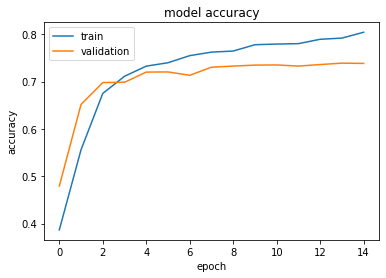

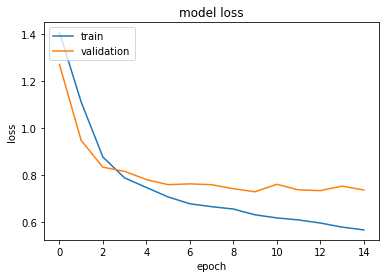

In [98]:

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [95]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [97]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

Accuracy: 17.10%

F1 Score: 17.10


In [44]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 73.83


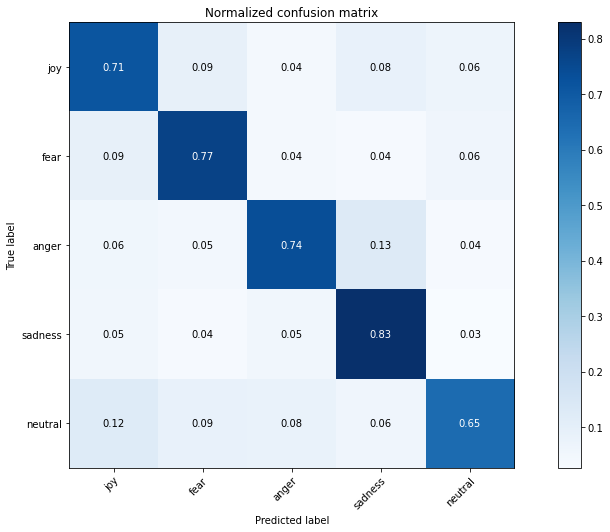

In [45]:
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(data_test.Emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [46]:
print('Message: {}\nPredicted: {}'.format(X_test[4], predictions[4]))

Message: My boyfriend didn't turn up after promising that he was coming.
Predicted: sadness


In [59]:
import time
message = ['How stupid you are?']
seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)
start_time = time.time()
pred = model.predict(padded)

In [60]:

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

Message: ['How stupid you are?']
predicted: anger (2.38 seconds)
